In [1]:
from theano.sandbox import cuda

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


In [2]:
#set FIXED variables
HOMEPATH = "/home/ubuntu/fastai/"

import os, errno
from datetime import datetime
import unidecode

In [3]:
os.chdir(HOMEPATH)
print ("current working directory:", os.getcwd())

%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

('current working directory:', '/home/ubuntu/fastai')


Using TensorFlow backend.


In [4]:
#path = "data/ml-20m/"
path = "data/ml-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [5]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [7]:
movie_names = pd.read_csv(path+'movies.csv', encoding = 'utf8').set_index('movieId')['title']#.to_dict()

print (type(movie_names), movie_names.shape)
print(movie_names[0:5]['title'])
for i in range(0, movie_names.shape[0]):
    print (movie_names.iloc[i]['title'])
    movie_names.iloc[i]['title'] = unidecode.unidecode(movie_names.iloc[i]['title'])
    print (movie_names.iloc[i]['title'])
print ("done")

In [8]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [9]:
print (type(users), users.shape)
print (type(movies), movies.shape)

<type 'numpy.ndarray'> (671,)
<type 'numpy.ndarray'> (9066,)


In [10]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}
print(type(userid2idx), len(userid2idx))
print(type(movieid2idx), len(movieid2idx))

print (next(iter(userid2idx)))


<type 'dict'> 671
<type 'dict'> 9066
1


We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [11]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [12]:
type(ratings)

pandas.core.frame.DataFrame

In [13]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
print (user_min, user_max, movie_min, movie_max)

0 670 0 9065


In [14]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [15]:
n_factors = 50

In [16]:
np.random.seed = 42

Randomly split into training and validation.

In [17]:
msk = np.random.rand(len(ratings)) < 0.8
#creates numpy array of True or False values with probably 80% true
print (type(msk), msk[0])
trn = ratings[msk]
val = ratings[~msk]

<type 'numpy.ndarray'> True


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [18]:
print (ratings.shape)
print (ratings[0:4])

g=ratings.groupby('userId')['rating'].count()
#group by 'userId', 'rating', count rows

print (type(g), g.shape)
print (g[0:4])
print (g.sort_values(ascending=False)[0:5])
topUsers=g.sort_values(ascending=False)[:15]
#select top 15 users.

(100004, 4)
   userId  movieId  rating   timestamp
0       0        0     2.5  1260759144
1       0        1     3.0  1260759179
2       0        2     3.0  1260759182
3       0        3     2.0  1260759185
<class 'pandas.core.series.Series'> (671,)
userId
0     20
1     76
2     51
3    204
Name: rating, dtype: int64
userId
546    2391
563    1868
623    1735
14     1700
72     1610
Name: rating, dtype: int64


In [19]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [20]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [21]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [22]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [23]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [24]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
#https://keras.io/models/model/

model.compile(Adam(0.001), loss='mse')
print (type(model))

<class 'keras.engine.training.Model'>


In [25]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))
#github gets loss: 9.8328 - val_loss: 3.7591 cf loss: 9.9450 - val_loss: 4.3126

Train on 80142 samples, validate on 19862 samples
Epoch 1/1
80142/80142 [==============================] - 5s - loss: 9.9450 - val_loss: 4.3126


In [26]:
model.optimizer.lr=0.01

In [27]:
print ("start")
startTime= datetime.now()
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))
timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))


start
Train on 80142 samples, validate on 19862 samples
Epoch 1/3
80142/80142 [==============================] - 4s - loss: 3.1456 - val_loss: 2.8174
Epoch 2/3
80142/80142 [==============================] - 4s - loss: 2.4245 - val_loss: 2.6104
Epoch 3/3
80142/80142 [==============================] - 4s - loss: 2.2554 - val_loss: 2.5601
Time elapsed (hh:mm:ss.ms) 0:00:14.530618


In [28]:
model.optimizer.lr=0.001

In [29]:
print ("start")
startTime= datetime.now()
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))
timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))
#github = loss: 2.0673 - val_loss: 1.4457 vs loss: 2.0542 - val_loss: 2.5753
#nb: loss is reducing, val_loss is not. loss is much less than val_loss overtraining?

start
Train on 80142 samples, validate on 19862 samples
Epoch 1/6
80142/80142 [==============================] - 4s - loss: 2.1896 - val_loss: 2.5566
Epoch 2/6
80142/80142 [==============================] - 4s - loss: 2.1507 - val_loss: 2.5513
Epoch 3/6
80142/80142 [==============================] - 4s - loss: 2.1211 - val_loss: 2.5538
Epoch 4/6
80142/80142 [==============================] - 4s - loss: 2.0978 - val_loss: 2.5589
Epoch 5/6
80142/80142 [==============================] - 4s - loss: 2.0741 - val_loss: 2.5687
Epoch 6/6
80142/80142 [==============================] - 4s - loss: 2.0542 - val_loss: 2.5753
Time elapsed (hh:mm:ss.ms) 0:00:29.115108


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [30]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)
#refer lesson 5 video @ 14"40'

In [31]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [32]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [33]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

refer video lesson 5 @ 27"08'"

In [34]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [35]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80142 samples, validate on 19862 samples
Epoch 1/1
80142/80142 [==============================] - 5s - loss: 8.8268 - val_loss: 3.5538


In [36]:
model.optimizer.lr=0.01

In [38]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=20, 
          validation_data=([val.userId, val.movieId], val.rating))
#github result = loss: 0.5747 - val_loss: 0.7979 vs my result after 6 epochs loss: 1.5886 - val_loss: 1.7878
#very bad result by comparison.
#after 20 epochs,  loss: 0.6405 - val_loss: 1.0564 both losses are consistently reducing. 
#loss is << val_loss so overfitting

Train on 80142 samples, validate on 19862 samples
Epoch 1/20
80142/80142 [==============================] - 5s - loss: 1.5141 - val_loss: 1.7266
Epoch 2/20
80142/80142 [==============================] - 5s - loss: 1.4422 - val_loss: 1.6685
Epoch 3/20
80142/80142 [==============================] - 5s - loss: 1.3730 - val_loss: 1.6130
Epoch 4/20
80142/80142 [==============================] - 5s - loss: 1.3066 - val_loss: 1.5593
Epoch 5/20
80142/80142 [==============================] - 5s - loss: 1.2436 - val_loss: 1.5077
Epoch 6/20
80142/80142 [==============================] - 5s - loss: 1.1828 - val_loss: 1.4588
Epoch 7/20
80142/80142 [==============================] - 5s - loss: 1.1254 - val_loss: 1.4114
Epoch 8/20
80142/80142 [==============================] - 5s - loss: 1.0703 - val_loss: 1.3700
Epoch 9/20
80142/80142 [==============================] - 5s - loss: 1.0183 - val_loss: 1.3292
Epoch 10/20
80142/80142 [==============================] - 5s - loss: 0.9691 - val_loss: 1.2886

In [39]:
model.optimizer.lr=0.001

In [41]:
startTime= datetime.now()
print ("startTime:", startTime)
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=20, 
          validation_data=([val.userId, val.movieId], val.rating))
timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))
#ran with 10 epochs then again with 20 epochs

startTime: 2017-11-22 09:07:04.474991
Train on 80142 samples, validate on 19862 samples
Epoch 1/20
80142/80142 [==============================] - 5s - loss: 0.5476 - val_loss: 1.0110
Epoch 2/20
80142/80142 [==============================] - 5s - loss: 0.5446 - val_loss: 1.0113
Epoch 3/20
80142/80142 [==============================] - 5s - loss: 0.5423 - val_loss: 1.0121
Epoch 4/20
80142/80142 [==============================] - 5s - loss: 0.5407 - val_loss: 1.0122
Epoch 5/20
80142/80142 [==============================] - 5s - loss: 0.5387 - val_loss: 1.0130
Epoch 6/20
80142/80142 [==============================] - 5s - loss: 0.5375 - val_loss: 1.0140
Epoch 7/20
80142/80142 [==============================] - 5s - loss: 0.5360 - val_loss: 1.0144
Epoch 8/20
80142/80142 [==============================] - 5s - loss: 0.5346 - val_loss: 1.0151
Epoch 9/20
80142/80142 [==============================] - 5s - loss: 0.5339 - val_loss: 1.0162
Epoch 10/20
80142/80142 [==============================] 

In [43]:
startTime= datetime.now()
print ("startTime:", startTime)
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=20, 
          validation_data=([val.userId, val.movieId], val.rating))
timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

#NB: video lecture val_loss is down to 0.7979 = refer lesson 5 @ 15"07'
#github results : loss: 0.5747 - val_loss: 0.7979
#ran w 5 epochs, loss is stabilising around 0.523 val_loss stabilising around 1.03
#quite different margins to the examples in github and video.

startTime: 2017-11-22 09:10:43.299576
Train on 80142 samples, validate on 19862 samples
Epoch 1/20
80142/80142 [==============================] - 5s - loss: 0.5239 - val_loss: 1.0277
Epoch 2/20
80142/80142 [==============================] - 5s - loss: 0.5235 - val_loss: 1.0283
Epoch 3/20
80142/80142 [==============================] - 5s - loss: 0.5231 - val_loss: 1.0284
Epoch 4/20
80142/80142 [==============================] - 5s - loss: 0.5231 - val_loss: 1.0290
Epoch 5/20
80142/80142 [==============================] - 5s - loss: 0.5229 - val_loss: 1.0296
Epoch 6/20
80142/80142 [==============================] - 5s - loss: 0.5225 - val_loss: 1.0309
Epoch 7/20
80142/80142 [==============================] - 5s - loss: 0.5223 - val_loss: 1.0313
Epoch 8/20
80142/80142 [==============================] - 5s - loss: 0.5220 - val_loss: 1.0312
Epoch 9/20
80142/80142 [==============================] - 5s - loss: 0.5219 - val_loss: 1.0312
Epoch 10/20
80142/80142 [==============================] 

This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [44]:
#model.save_weights(model_path+'bias.h5')

In [45]:
#model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [46]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.7756]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [47]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [48]:
print (type(movie_in))
print (type(mb))
print (type(topMovies), topMovies.shape)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<type 'numpy.ndarray'> (2000,)


In [49]:
get_movie_bias = Model(movie_in, mb)
#does a lookup in the movie bias table
#keras.models.Model
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [50]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-1.2702248, u'Battlefield Earth (2000)'),
 (-1.1387031, u'Police Academy 6: City Under Siege (1989)'),
 (-0.97421765, u'Super Mario Bros. (1993)'),
 (-0.95036471, u'Jaws 3-D (1983)'),
 (-0.93478054, u'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.91206694, u'Howard the Duck (1986)'),
 (-0.85384089, u'Blade: Trinity (2004)'),
 (-0.83160985, u'Bio-Dome (1996)'),
 (-0.81913114, u'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.74457854, u'Speed 2: Cruise Control (1997)'),
 (-0.73113656, u'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.65679651, u'House on Haunted Hill (1999)'),
 (-0.61949652, u'I Still Know What You Did Last Summer (1998)'),
 (-0.60725164, u'Spice World (1997)'),
 (-0.5554738, u'Children of the Corn (1984)')]

In [51]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(2.0213404, u'Night at the Opera, A (1935)'),
 (1.9146923, u'Inherit the Wind (1960)'),
 (1.8878522, u'Happiness (1998)'),
 (1.8786311, u'Mister Roberts (1955)'),
 (1.8622547, u'It Happened One Night (1934)'),
 (1.857764, u'Tom Jones (1963)'),
 (1.8463682, u'American Movie (1999)'),
 (1.8316568, u'All About Eve (1950)'),
 (1.8293188, u'Ran (1985)'),
 (1.8285356, u'Treasure of the Sierra Madre, The (1948)'),
 (1.8244284, u'Capturing the Friedmans (2003)'),
 (1.8210113, u'Modern Times (1936)'),
 (1.8208256, u'On the Waterfront (1954)'),
 (1.8130056, u'Shawshank Redemption, The (1994)'),
 (1.8002242, u'Godfather, The (1972)')]

We can now do the same thing for the embeddings.

In [52]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [54]:
fac0 = movie_pca[0]

In [55]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [56]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.11665931, u'Independence Day (a.k.a. ID4) (1996)'),
 (0.090704143, u'Armageddon (1998)'),
 (0.076003678, u'Shrek (2001)'),
 (0.075910605, u'Mission: Impossible II (2000)'),
 (0.074597523, u'Patriot, The (2000)'),
 (0.073236741, u'Titanic (1997)'),
 (0.071595296, u'Stargate (1994)'),
 (0.068182647, u'Shrek 2 (2004)'),
 (0.066456169, u'Pearl Harbor (2001)'),
 (0.062055681, u"Pirates of the Caribbean: Dead Man's Chest (2006)")]

In [57]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.11327758, u'Pulp Fiction (1994)'),
 (-0.097657353, u'Clockwork Orange, A (1971)'),
 (-0.09536916, u'Fargo (1996)'),
 (-0.08695963, u'Apocalypse Now (1979)'),
 (-0.086897597, u'Royal Tenenbaums, The (2001)'),
 (-0.082712196, u'Willy Wonka & the Chocolate Factory (1971)'),
 (-0.082164735, u'Being John Malkovich (1999)'),
 (-0.077449106, u'Taxi Driver (1976)'),
 (-0.075989664, u'Blade Runner (1982)'),
 (-0.074038446, u'2001: A Space Odyssey (1968)')]

In [58]:
fac1 = movie_pca[1]

In [59]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [60]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.068766542, u'Charlie and the Chocolate Factory (2005)'),
 (0.067084566, u'Postman, The (Postino, Il) (1994)'),
 (0.059216134, u"Amelie (Fabuleux destin d'Am\xe9lie Poulain, Le) (2001)"),
 (0.055328328, u'About Schmidt (2002)'),
 (0.053916242, u'Ransom (1996)'),
 (0.053109448, u'Bend It Like Beckham (2002)'),
 (0.052312374, u'Slumdog Millionaire (2008)'),
 (0.051482275, u'Little Miss Sunshine (2006)'),
 (0.051272888, u'Eraser (1996)'),
 (0.051103789, u'Some Like It Hot (1959)')]

In [61]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.1696801, u'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.15917815, u'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.14484982, u'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.13138521, u'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.11622342, u'Dances with Wolves (1990)'),
 (-0.11221141, u'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.10505352, u'Matrix, The (1999)'),
 (-0.10370874, u'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.10238157, u'Gladiator (2000)'),
 (-0.098412827, u'Die Hard (1988)')]

In [62]:
fac2 = movie_pca[2]

In [63]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [64]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.14158884, u'Beauty and the Beast (1991)'),
 (0.11268232, u"Schindler's List (1993)"),
 (0.10461111, u'Aladdin (1992)'),
 (0.10095945, u'Babe (1995)'),
 (0.096201822, u'Lord of the Rings: The Return of the King, The (2003)'),
 (0.092807785, u'Lion King, The (1994)'),
 (0.090274438, u'Dances with Wolves (1990)'),
 (0.089305967, u'Erin Brockovich (2000)'),
 (0.088772483, u'Chicken Run (2000)'),
 (0.08390598, u'Star Wars: Episode IV - A New Hope (1977)')]

In [65]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.094402127, u'Happy Gilmore (1996)'),
 (-0.089387052, u'Eyes Wide Shut (1999)'),
 (-0.084477209, u'Natural Born Killers (1994)'),
 (-0.077264532, u'Back to the Future Part II (1989)'),
 (-0.076121554, u'American Psycho (2000)'),
 (-0.073916532, u'Army of Darkness (1993)'),
 (-0.072094366, u'Clockwork Orange, A (1971)'),
 (-0.071405448, u'Fear and Loathing in Las Vegas (1998)'),
 (-0.070300482, u'Outbreak (1995)'),
 (-0.070167296, u'Zoolander (2001)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [66]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr


In [67]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
print (type(X), X.shape)
print (type(Y), Y.shape)

print (type(topMovies), topMovies.shape)

<type 'numpy.ndarray'> (50,)
<type 'numpy.ndarray'> (50,)
<type 'numpy.ndarray'> (2000,)


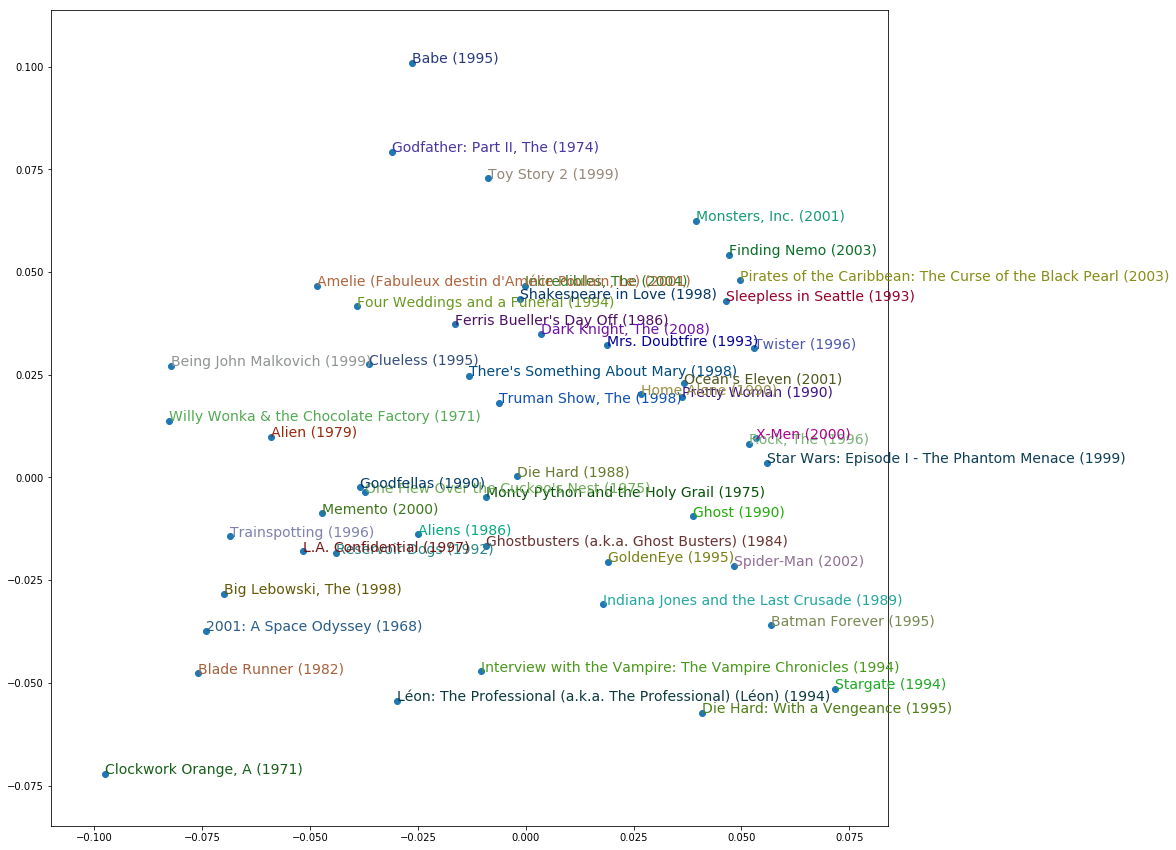

In [68]:
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
    #print (x,y,movies[i], movie_names[movies[i]])
    #plt.text(x,y,movie_names[movies[i]], color='red', fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [75]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)
print ("user_in:", type(user_in))
print ("movie_in:", type(movie_in))
print ("u:", type(u))
print ("m:", type(m))

user_in: <class 'tensorflow.python.framework.ops.Tensor'>
movie_in: <class 'tensorflow.python.framework.ops.Tensor'>
u: <class 'tensorflow.python.framework.ops.Tensor'>
m: <class 'tensorflow.python.framework.ops.Tensor'>


In [80]:
x = merge([u, m], mode='concat')
print ("x:", type(x))
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
print ("nn:", type(nn), type(nn.layers))
print ("type(nn.layers[0]:", type(nn.layers[0]))
print (nn.summary())
nn.compile(Adam(0.001), loss='mse')

x: <class 'tensorflow.python.framework.ops.Tensor'>
nn: <class 'keras.engine.training.Model'> <type 'list'>
type(nn.layers[0]: <class 'keras.engine.topology.InputLayer'>
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_11 (Embedding)         (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_12 (Embeddin

In [82]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=40, 
          validation_data=([val.userId, val.movieId], val.rating))

#lesson 5 video @ 15"15' returned val_loss 0.7943

Train on 80142 samples, validate on 19862 samples
Epoch 1/40
80142/80142 [==============================] - 6s - loss: 0.7881 - val_loss: 0.8271
Epoch 2/40
80142/80142 [==============================] - 6s - loss: 0.7884 - val_loss: 0.8241
Epoch 3/40
80142/80142 [==============================] - 6s - loss: 0.7906 - val_loss: 0.8242
Epoch 4/40
80142/80142 [==============================] - 6s - loss: 0.7865 - val_loss: 0.8287
Epoch 5/40
80142/80142 [==============================] - 6s - loss: 0.7875 - val_loss: 0.8281
Epoch 6/40
80142/80142 [==============================] - 6s - loss: 0.7861 - val_loss: 0.8254
Epoch 7/40
80142/80142 [==============================] - 6s - loss: 0.7843 - val_loss: 0.8262
Epoch 8/40
80142/80142 [==============================] - 6s - loss: 0.7854 - val_loss: 0.8261
Epoch 9/40
80142/80142 [==============================] - 6s - loss: 0.7847 - val_loss: 0.8300
Epoch 10/40
80142/80142 [==============================] - 6s - loss: 0.7837 - val_loss: 0.8255

This improves on our already impressive accuracy even further!

Epoch 8/8
79907/79907 [==============================] - 13s - loss: 0.8087 - val_loss: 0.8274

after 8 epochs : loss: 0.8078 - val_loss: 0.8307
running again w 2- epochs : 